In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive"
os.chdir(path)

import pandas as pd
data_path = 'risk_factors_cervical_cancer.csv'
data=pd.read_csv(data_path)
labels = data.columns.values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Replace ?s with 0 to represent missing values
data=data.replace("?", 0)

cat_cols = data.select_dtypes(['object']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: pd.to_numeric(x))

from sklearn.model_selection import train_test_split
#Split data into training and testing sets
y=data["Biopsy"]
X=data.drop(["Biopsy",'Schiller','Hinselmann','Citology'], axis=1)
#30% of dataset goes to test set
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
import xgboost as xgb
#Train the XGBClassifier using training data

xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5, objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#Evaluating the classifier using training set
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 31 20:05:23 2017

@author: DIP
"""

from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, classes=classes)
    print('\nPrediction Confusion Matrix: - Error - Please Proceed')

def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),linewidth=2.5)
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)
        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)
        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()



In [ ]:
# Model Performance Evaluation
class_labels = list(set(labels))
display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.9341
Precision: 0.9045
Recall: 0.9341
F1 Score: 0.9158

Model Classification report:
------------------------------
                                    precision    recall  f1-score   support

  STDs:pelvic inflammatory disease       0.00      0.00      0.00         0
                               Age       0.00      0.00      0.00         0
                       IUD (years)       0.00      0.00      0.00         0
      STDs:cervical condylomatosis       0.00      0.00      0.00         0
                        Hinselmann       0.00      0.00      0.00         0
                            Dx:CIN       0.00      0.00      0.00         0
                          Citology       0.00      0.00      0.00         0
                     STDs:syphilis       0.00      0.00      0.00         0
                  STDs:Hepatitis B       0.00      0.00      0.00         0
                          STDs:HPV       0.00      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: Und

In [ ]:
!pip install shap
import shap
# explain test dataset with XGBoost
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,0.687335,-1.363214,-1.506206,-0.478446,0.045451,0.021746,-0.088481,-0.460470,-0.313648,0.001236,-0.008778,-0.168018,0.0,0.0,0.0,0.0,-0.057006,0.0,0.0,0.0,0.0,0.0,-0.019479,0.0,0.0,-0.042621,0.040574,0.0,0.0,0.0,-0.058663,-0.090102
1,-1.628302,0.830422,0.457478,-0.351455,0.049030,0.021158,-0.087369,-0.927585,0.546399,0.001236,-0.015257,-0.308871,0.0,0.0,0.0,0.0,-0.098370,0.0,0.0,0.0,0.0,0.0,-0.024919,0.0,0.0,-0.023978,0.036314,0.0,0.0,0.0,-0.041551,-0.098046
2,-0.587830,-1.341261,-2.424690,-0.161304,0.053467,0.031317,-0.080292,-0.423417,-0.996824,0.001236,-0.045713,-0.128096,0.0,0.0,0.0,0.0,-0.077211,0.0,0.0,0.0,0.0,0.0,-0.019841,0.0,0.0,-0.047157,0.045744,0.0,0.0,0.0,-0.056438,-0.081575
3,-0.654481,0.510287,-0.829918,-0.387903,0.055807,0.018150,-0.076767,0.398827,-0.171920,0.001236,-0.021433,-0.120173,0.0,0.0,0.0,0.0,-0.092166,0.0,0.0,0.0,0.0,0.0,-0.022055,0.0,0.0,-0.044162,0.043763,0.0,0.0,0.0,-0.038649,-0.067185
4,-1.591534,-0.098050,0.027711,-0.246060,-0.492778,0.031502,-0.088483,-0.050565,-0.316116,0.001236,-0.003390,-0.175228,0.0,0.0,0.0,0.0,-0.054620,0.0,0.0,0.0,0.0,0.0,-0.022602,0.0,0.0,-0.050961,0.036422,0.0,0.0,0.0,-0.051819,-0.095433


In [ ]:
print('Expected Value:', explainer.expected_value)

Expected Value: -2.8389945


In [ ]:
# Predicting when a person has no cervical cancer
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
# Predicting when a person has cervical cancer
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5,:], X_test.iloc[5,:])

In [ ]:
# visualize model prediction decisions for test data samples
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:], X_test.iloc[:,:])

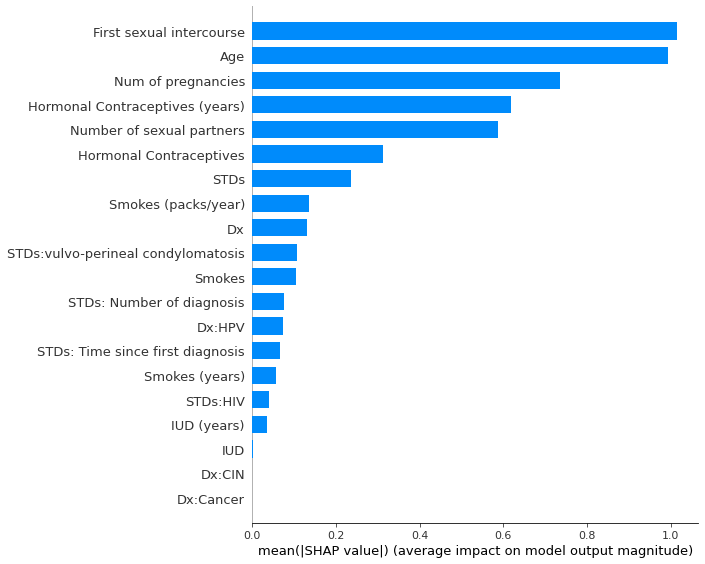

In [ ]:
# Feature Importances with SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar")

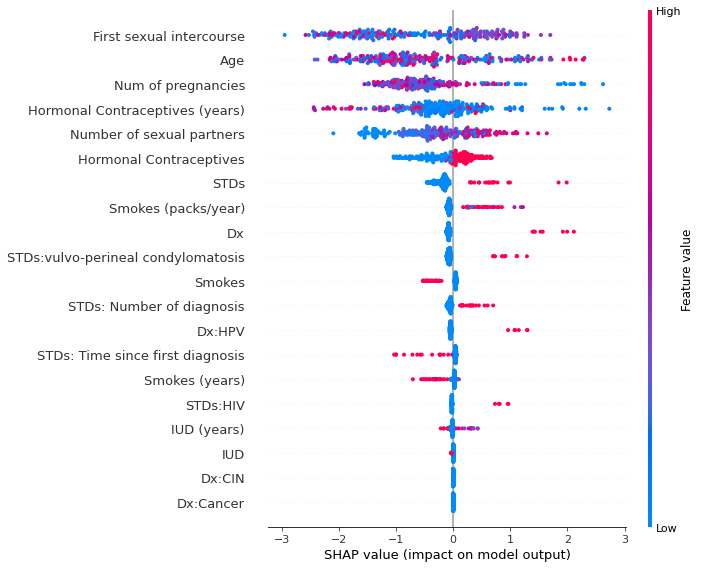

In [ ]:
# use a density scatter plot of SHAP values for each feature to identify
shap.summary_plot(shap_values, X_test)

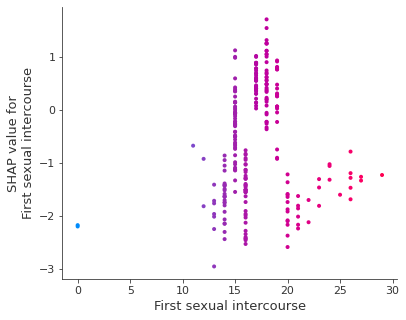

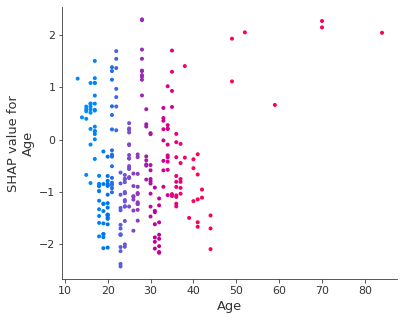

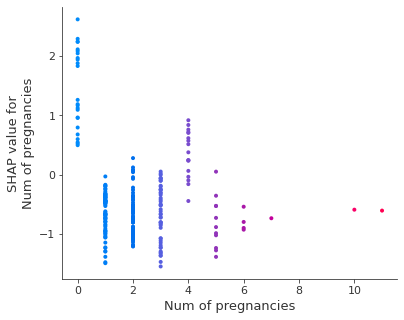

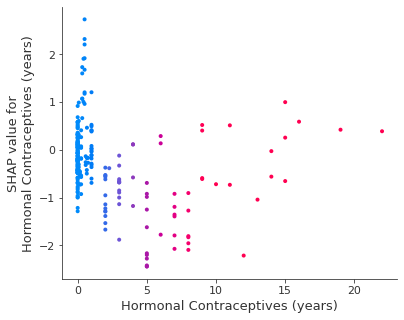

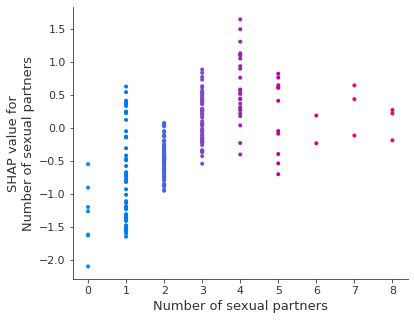

In [ ]:
# The partial dependence plot(PDP) of 'First sexual intercourse' affecting model prediction
shap.dependence_plot(ind='First sexual intercourse', interaction_index='First sexual intercourse',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)
# The partial dependence plot(PDP) of 'Age' affecting model prediction
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)
# The partial dependence plot(PDP) of 'Num of pregnancies' affecting model prediction
shap.dependence_plot(ind='Num of pregnancies', interaction_index='Num of pregnancies',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)
# The partial dependence plot(PDP) of 'Hormonal Contraceptives (years)' affecting model prediction
shap.dependence_plot(ind='Hormonal Contraceptives (years)', interaction_index='Hormonal Contraceptives (years)',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)
# The partial dependence plot(PDP) of 'Number of sexual partners' affecting model prediction
shap.dependence_plot(ind='Number of sexual partners', interaction_index='Number of sexual partners',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)


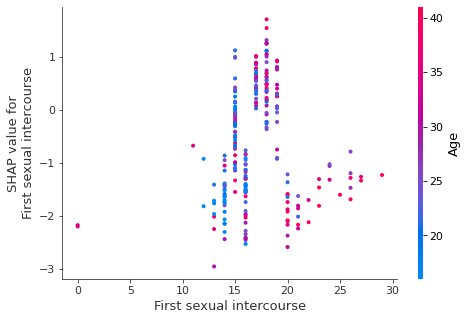

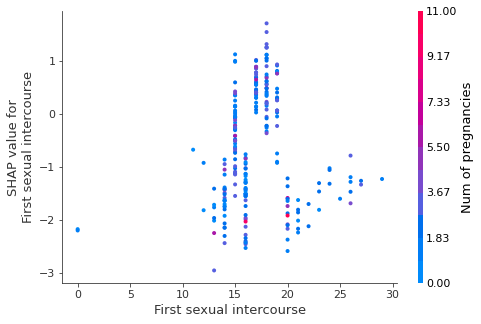

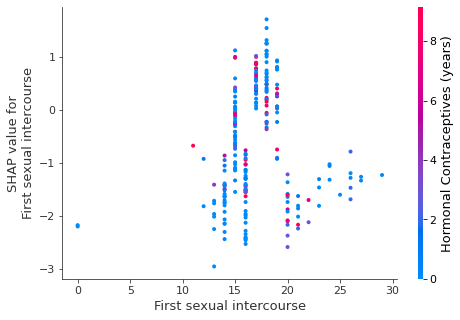

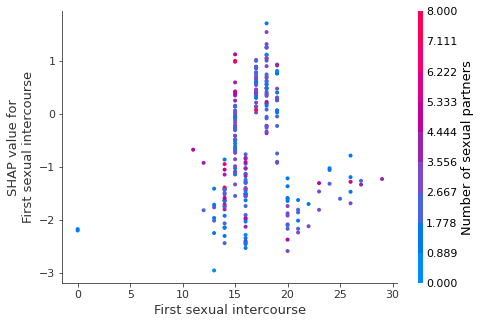

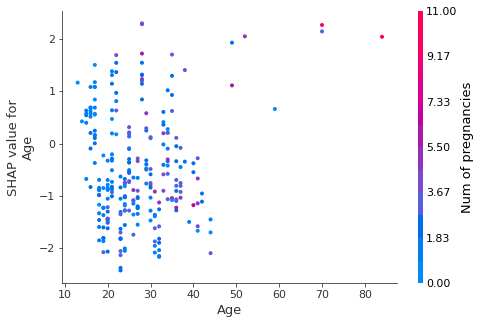

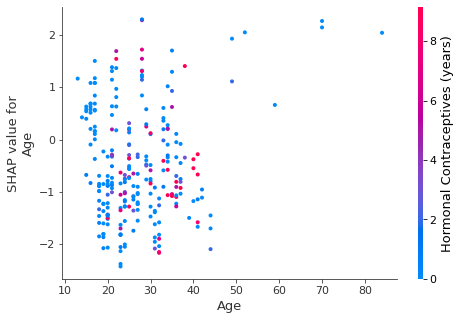

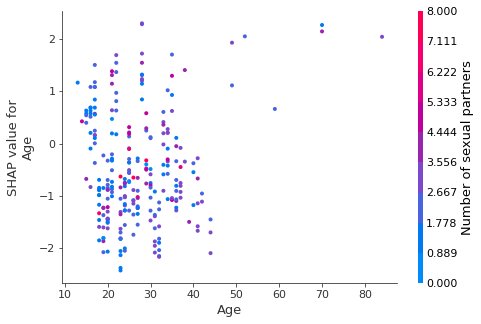

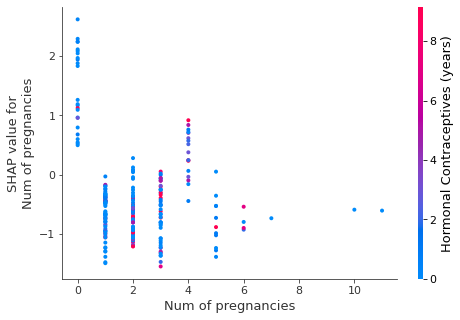

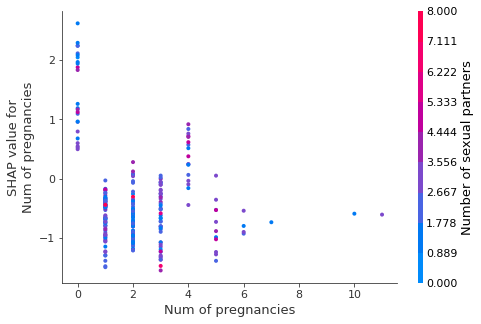

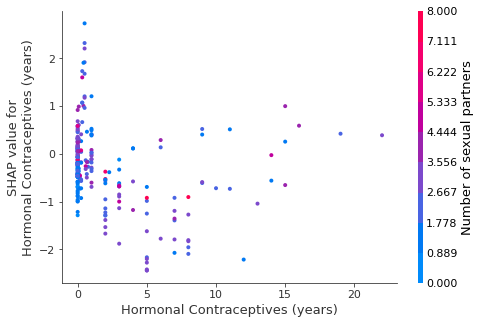

In [ ]:
shap.dependence_plot(ind='First sexual intercourse', interaction_index='Age', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)
shap.dependence_plot(ind='First sexual intercourse', interaction_index='Num of pregnancies', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)
shap.dependence_plot(ind='First sexual intercourse', interaction_index='Hormonal Contraceptives (years)', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)
shap.dependence_plot(ind='First sexual intercourse', interaction_index='Number of sexual partners', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

shap.dependence_plot(ind='Age', interaction_index='Num of pregnancies', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)
shap.dependence_plot(ind='Age', interaction_index='Hormonal Contraceptives (years)', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)
shap.dependence_plot(ind='Age', interaction_index='Number of sexual partners', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

shap.dependence_plot(ind='Num of pregnancies', interaction_index='Hormonal Contraceptives (years)', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)
shap.dependence_plot(ind='Num of pregnancies', interaction_index='Number of sexual partners', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

shap.dependence_plot(ind='Hormonal Contraceptives (years)', interaction_index='Number of sexual partners',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)